<a name='introduction'></a>
# Проект "Анализ постов на habr.com"

В рамках данного проекта необходимо осуществить парсинг данных с веб-сайта. В качества веб-сайта взят habr.com. Необходимо осуществить парсинг лучших постов за все время. Данные для парсинга: 1) параметры - наименование статьи, дата загрузки, категория, к которой пост относится; количество голосов и 2) целевой показатель - число просмотров. 

Параметр 'количество голосов' можно также использовать как целевой показатель, поэтому и информация по нему была собрана. Более того, рейтинг постов определяется именно количеством голосов, а не просмотров. Однако в качестве независимого параметра 'количество голосов' не подходит, поскольку может сильно зависеть от количества просмотров. 

В дальнейшем можно рассмотреть не только лучшие за все время посты, но и увеличить выборку еще б**о**льшим объемом повседневных постов.

Объем выборки составил 997 статей (для 3 не было обнаружено количество просмотров, поэтому от них решено было избавиться. В дополнение, результат работы парсера (база данных) был сохранен в отдельный файл 'posts_data.csv')

<br>**План проекта**:
1. [Импортирование библиотек](#import)
2. [Парсинг данных](#parsing)
3. [Предобработка данных и Feature Engineering](#preprocessing)
    - [Типы данных](#dtypes)
    - [Проверка на аномальные значения](#anomalies)
    - [Feature Engineering](#feature_engineering)
4. [Исследовательский анализ данных](#eda)
    - [Количество постов по годам](#posts_per_year)
    - [Количество постов по категориям](#posts_categories)
    - [Категории постов по годам публикаций](#categories_per_year)
    - [Количество просмотров по дате](#views_per_date)
        - [Количество просмотров по году публикации](#views_per_year)
        - [Количество просмотров по месяцам](#views_per_month)
        - [Количество просмотров по дням](#views_per_day)
        - [Количество просмотров по часам](#views_per_hour)
        - [Количество просмотров по минутам](#views_per_minute)
    - [Количество просмотров по категориям](#views_per_category)
    - [Самые популярные слова в названиях постов](#popular_words)
        - [По частоте упоминаний](#words_per_frequency)
        - [По обществу количеству просмотров](#words_per_views)
        - [По количеству голосов](#words_per_votes)

<a name='import'></a>
## 1. Импортирование библиотек
[Введение](#introduction)

In [503]:
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options
import time

import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

<a name='parsing'></a>
## 2. Парсинг данных
[Введение](#introduction)

Для осуществления парсинга воспользуемся библиотекой selenium. Необходимо получить названия статей, дату их публикации, категории, к которым они относятся, количество голосов и количество просмотров. Для этого будем осуществлять парсинг с помощью бразуера Firefox 50 страниц постов с сайта habr.com по количеству голосов.

In [41]:
firefox_opt = Options()
firefox_opt.page_load_strategy = 'eager'
driver = webdriver.Firefox(options=firefox_opt)

habr_url = 'https://habr.com/ru/top/alltime/'

In [42]:
# Функция для получения данных с одной веб-страницы
def get_page_data(page_num):
    # Заход на веб-страницу
    page_url = f'{habr_url}page{page_num}'
    driver.get(page_url)
    driver.implicitly_wait(5)
    
    # Прокрутка до конца страницы
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
    # Наименования постов
    titles = [title.text for title in driver.find_elements(By.CLASS_NAME, 'tm-title__link')]
    
    # Количество просмотров
    view_counts_link = driver.find_elements(By.CLASS_NAME, 'tm-icon-counter__value')
    view_counts = []
    for view_count in view_counts_link:
        if 'M' in view_count.text:
            view_counts.append(float(re.split('M', view_count.text)[0]) * 1000)
        elif 'K' in view_count.text:
            view_counts.append(float(re.split('K', view_count.text)[0]))
    
    # Категории
    categories_link = driver.find_elements(By.CLASS_NAME, 'tm-article-snippet__hubs-container')
    categories = []
    for category in categories_link:
        categories.append([i for i in re.split('\n', category.text) if i != '*'])

    # Дата и время публикации
    dates_link = driver.find_elements(By.CSS_SELECTOR, 'time')
    dates = [date.get_attribute('datetime') for date in dates_link if 'в' in date.text]
    
    # Количество голосов
    votes_link = driver.find_elements(By.CLASS_NAME, 'tm-votes-meter.tm-data-icons__item')
    votes = [int(vote.text.split('+')[1]) for vote in votes_link]
    
    # Объединение собранных данных в датафрейм
    df = pd.concat(
        [pd.Series(titles), pd.Series(view_counts), pd.Series(categories), pd.Series(dates), pd.Series(votes)],
        axis=1
    )
    df.columns = ['title', 'view_count', 'category', 'date', 'votes']
    
    return df

In [43]:
# Получим данные с каждой страницы топ-50 по постам
df_posts = pd.DataFrame(columns=['title', 'view_count', 'category', 'date'])

for n in range(1, 51):
    df_posts = df_posts.append(get_page_data(n), ignore_index=True)

driver.quit()

In [45]:
# Получим количество пропущенных значений по каждому столбцу
df_posts.isna().sum()

title         0
view_count    3
category      0
date          0
votes         0
dtype: int64

In [46]:
# Избавимся от постов, для которых не было обнаружено 'view_count' (их всего 3) 
df_posts = df_posts[~df_posts['view_count'].isna()].reset_index(drop=True)
df_posts.head()

,title,view_count,category,date,votes
0,Делаем приватный монитор из старого LCD монитора,958.0,[DIY или Сделай сам],2011-11-27T19:21:13.000Z,1448.0
1,Самый беззащитный — уже не Сапсан. Всё оказало...,524.0,"[Информационная безопасность, Системное админи...",2021-01-13T05:51:41.000Z,1447.0
2,Были получены исходники 3300 глобальных интерн...,268.0,[Информационная безопасность],2009-09-23T09:17:27.000Z,1154.0
3,История игрушки. Поле Чудес,290.0,"[История IT, Игры и игровые консоли]",2011-07-18T08:23:11.000Z,913.0
4,"[Обновлено в 10:52, 14.12.19] В офисе Nginx пр...",311.0,"[Блог компании ITSumma, Nginx, Законодательств...",2019-12-12T12:34:52.000Z,791.0


In [47]:
# Сохраним базу данных в отдельный файл 'posts_data.csv'
df_posts.to_csv('posts_data.csv')

<a name='preprocessing'></a>
## 3. Предобработка данных и Feature Enginnering
[Введение](#introduction)

Рассмотрим типы данных каждого из столбца и, в случае необходимости, поменяем их.

<a name='dtypes'></a>
### 3. 1. Типы данных
[Введение](#introduction)

In [5]:
# Скачаем сохраненную ранее базу данных
df_posts = pd.read_csv('posts_data.csv', index_col=0)
df_posts.head()

In [7]:
# Типы данных каждого параметра
df_posts.dtypes

title          object
view_count    float64
category       object
date           object
votes         float64
dtype: object

Можно заметить, что у параметра 'date' тип данных - object, а необходим datatime. Исправим это, поменяв на нужный тип данных. Это позволит создать дополнительные параметры отдельно по году, месяцу, дню, часу и минуте публикации.

In [8]:
df_posts['date'] = pd.to_datetime(df_posts['date'])
df_posts['date'].head()

0   2011-11-27 19:21:13+00:00
1   2021-01-13 05:51:41+00:00
2   2009-09-23 09:17:27+00:00
3   2011-07-18 08:23:11+00:00
4   2019-12-12 12:34:52+00:00
Name: date, dtype: datetime64[ns, UTC]

In [31]:
df_posts['category'] = df_posts['category'].apply(literal_eval)

<a name='anomalies'></a>
### 3. 2. Проверка на аномальные значения 
[Введение](#introduction)

Осуществим проверку значений на аномалии. Для этого посмотрим размах значений по таким параметрам, как 'view_count', 'votes'. Взгляним также, возможно ли объединить некоторые категории между собой, если они похожи, например (столбец 'category').

In [20]:
print("Размах значений по параметру 'view_count':")
display(df_posts['view_count'].sort_values(ascending=False))
print("\nРазмах значений по параметру 'votes':")
display(df_posts['votes'].sort_values(ascending=False))

Размах значений по параметру 'view_count':


67     5600.0
11     1700.0
321    1600.0
465    1500.0
948    1400.0
        ...  
298       1.5
782       1.4
714       1.4
844       1.2
761       1.0
Name: view_count, Length: 997, dtype: float64


Размах значений по параметру 'votes':


0      1448.0
1      1447.0
2      1154.0
3       913.0
4       791.0
        ...  
987     225.0
986     225.0
985     225.0
984     225.0
996     225.0
Name: votes, Length: 997, dtype: float64

Посмотрим на посты, у которых 2 и менее тыс. просмотров, но которые относятся к лучшим на Habr.com

In [52]:
df_posts[df_posts['view_count'] <= 2]

,title,view_count,category,date,votes
298,"Злые вы, уйду я от вас… или Кто ты, хабровчанин?",1.5,[Социальные сети и сообщества],2009-07-21 07:36:36+00:00,318.0
399,Кредит,1.5,[Финансы в IT],2010-05-05 18:24:26+00:00,297.0
701,Почтовый Дымовский. Попробуем достучаться до в...,1.9,[Социальные сети и сообщества],2010-03-17 05:36:07+00:00,250.0
714,Использование IPv4 адресов с российским размахом,1.4,[Ненормальное программирование],2010-06-12 19:46:22+00:00,249.0
761,Google vs Microsoft,1.0,[Информационная безопасность],2008-10-29 17:12:10+00:00,244.0
772,"Ты на Суперхабре, %username%!",1.7,[Habr],2008-08-10 23:01:55+00:00,243.0
782,Союзмультфильм на YouTube,1.4,[Социальные сети и сообщества],2011-03-11 21:12:27+00:00,242.0
825,"Грамматический треугольник: дети, орфография и...",2.0,[Читальный зал],2008-08-17 21:02:15+00:00,238.0
844,Провайдер заблокировал доступ к блогу Навально...,1.2,[Законодательство в IT],2011-05-17 15:57:30+00:00,236.0
896,"Чего стесняемся, Google?",1.9,[Терминология IT],2011-08-12 08:23:02+00:00,232.0


В рассмотренных количественных параметрах никаких аномалий обнаружено не было. Примечательно, что наименее просматриваемые посты датируются 2008-2011 гг. Вероятно, вовлеченность каждого читателя на сайт была выше, нежели сейчас, что объясняется довольно высоким показателем голосов (параметр 'vote'), по которому Habr и рассчитывает рейтинг постов.

In [219]:
# Отберем уникальные категории и отобразим их списком
unique_categories = []
for key, category_list in enumerate(df_posts['category']):
    for category in category_list:
        if category not in unique_categories:
            unique_categories.append(category)

unique_categories_series = np.array(pd.Series(unique_categories).sort_values())
unique_categories_series

array(['*nix', '.NET', '3D-принтеры', 'API', 'AR и VR', 'Accessibility',
       'Adobe Flash', 'Assembler', 'Big Data', 'C', 'C#', 'C++', 'CSS',
       'DIY или Сделай сам', 'Data Mining', 'DevOps', 'ERP-системы',
       'FPGA', 'GPGPU', 'GTD', 'GitHub', 'Go', 'Google API',
       'Google Chrome', 'Google Cloud Platform', 'HTML', 'Habr', 'I2P',
       'INFOLUST', 'IT-инфраструктура', 'IT-компании', 'IT-стандарты',
       'IT-эмиграция', 'Internet Explorer', 'Java', 'JavaScript',
       'Kotlin', 'Lua', 'MODX', 'Natural Language Processing', 'Nginx',
       'NoSQL', 'Node.JS', 'Open source', 'Opera', 'PHP', 'PostgreSQL',
       'Puppet', 'Python', 'R', 'ReactJS', 'Ruby', 'Ruby on Rails',
       'Rust', 'SQL', 'SQLite', 'SaaS / S+S', 'TypeScript', 'UEFI',
       'Unity', 'Usability', 'VIM', 'Visual Basic for Applications',
       'WebAssembly', 'jQuery', 'Автомобильные гаджеты',
       'Администрирование баз данных', 'Администрирование доменных имен',
       'Алгоритмы', 'Анализ и проект

Отображение уникальных категорий также помогло определить, что опечатки в названиях категорий или схожие категории отсутствуют. Ввиду чего они остаются без изменений.

<a name='feature_engineering'></a>
### 3. 3. Feature Engineering
[Введение](#introduction)

In [54]:
# Создадим отдельные переменные с годом, месяцем, днем, часом и минутой публикации
df_posts['year'] = df_posts['date'].dt.year
df_posts['month'] = df_posts['date'].dt.month
df_posts['day'] = df_posts['date'].dt.day
df_posts['hour'] = df_posts['date'].dt.hour
df_posts['minute'] = df_posts['date'].dt.minute

df_posts = df_posts.drop('date', axis=1)

In [55]:
# Проверим типы данных и количество пропущенных значений
print("Типы данных:")
display(df_posts.dtypes)

print("Пропущенные значения:")
display(df_posts.isna().sum())

Типы данных:


title          object
view_count    float64
category       object
votes         float64
year            int64
month           int64
day             int64
hour            int64
minute          int64
dtype: object

Пропущенные значения:


title         0
view_count    0
category      0
votes         0
year          0
month         0
day           0
hour          0
minute        0
dtype: int64

In [56]:
df_posts.head()

,title,view_count,category,votes,year,month,day,hour,minute
0,Делаем приватный монитор из старого LCD монитора,958.0,[DIY или Сделай сам],1448.0,2011,11,27,19,21
1,Самый беззащитный — уже не Сапсан. Всё оказало...,524.0,"[Информационная безопасность, Системное админи...",1447.0,2021,1,13,5,51
2,Были получены исходники 3300 глобальных интерн...,268.0,[Информационная безопасность],1154.0,2009,9,23,9,17
3,История игрушки. Поле Чудес,290.0,"[История IT, Игры и игровые консоли]",913.0,2011,7,18,8,23
4,"[Обновлено в 10:52, 14.12.19] В офисе Nginx пр...",311.0,"[Блог компании ITSumma, Nginx, Законодательств...",791.0,2019,12,12,12,34


<a name='eda'></a>
## 4. Исследовательский анализ данных
[Введение](#introduction)

Осуществим исследовательский анализ данных. Рассмотрим следующее:
- [Количество постов по годам](#posts_per_year)
- [Количество постов по категориям](#posts_categories)
- [Категории постов по годам публикаций](#categories_per_year)
- [Количество просмотров по дате](#views_per_date)
    - [Количество просмотров по году публикации](#views_per_year)
    - [Количество просмотров по месяцам](#views_per_month)
    - [Количество просмотров по дням](#views_per_day)
    - [Количество просмотров по часам](#views_per_hour)
    - [Количество просмотров по минутам](#views_per_minute)
- [Количество просмотров по категориям](#views_per_category)
- [Самые популярные слова в названиях](#popular_words)
    - [По частоте упоминаний](#words_per_frequency)
    - [По обществу количеству просмотров](#words_per_views)
    - [По количеству голосов](#words_per_votes)

In [57]:
# Определим необходимые размеры для текста графиков
LABEL_FONTSIZE = 14
TICK_FONTSIZE = 13
TITLE_FONTSIZE = 16

<a name='posts_per_year'></a>
### 4. 1. Количество постов по годам
[Введение](#introduction)

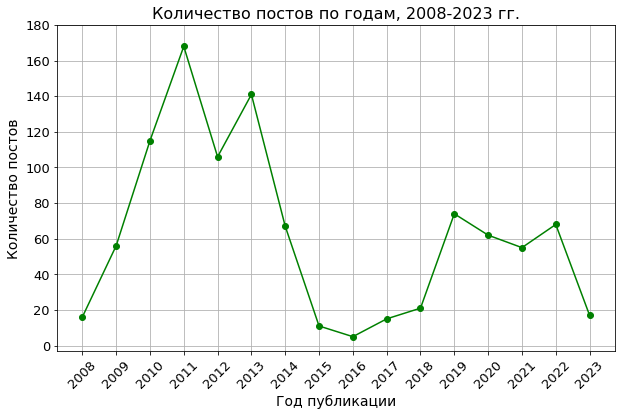

In [58]:
posts_per_year = df_posts.pivot_table(index='year', values='title', aggfunc='count').reset_index()
posts_per_year.columns = ['year', 'count']

plt.figure(figsize=(10,6))

plt.plot(
    posts_per_year['year'],
    posts_per_year['count'],
    '-o',
    color='green',
)

plt.grid()
plt.title('Количество постов по годам, 2008-2023 гг.', fontsize=TITLE_FONTSIZE)
plt.xlabel('Год публикации', fontsize=LABEL_FONTSIZE)
plt.xticks(range(2008, 2024), rotation=45, fontsize=TICK_FONTSIZE)
plt.ylabel('Количество постов', fontsize=LABEL_FONTSIZE)
plt.yticks(range(0, 181, 20), fontsize=TICK_FONTSIZE)
plt.show()

Наибольшее число постов приходится на период с 2010-2013 гг., в то время как в период с 2015 по 2018 гг. наблюдается снижение количества постов, которые находятся в топе по количеству голосов. Возможно, это связано с общим снижением количества публикуемых постов, однако данная гипотеза не может быть ни подтверждена, ни опровергнута ввиду недостатка информации (поиск информации в открытых источниках о количество постов по годам оказался безрезультатным)

<a name='posts_categories'></a>
### 4. 2. Количество постов по категориям
[Введение](#introduction)

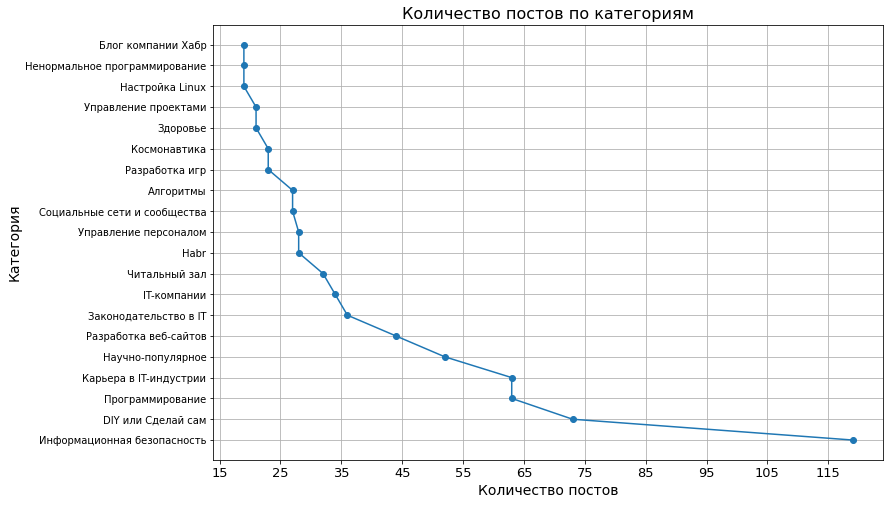

In [59]:
# Отобразим на графике количество 20-и самых популярных по количеству постов категорий
categories_count = df_posts['category'].explode().value_counts().reset_index()
categories_count.columns = ['category', 'count']

plt.figure(figsize=(12, 8))

plt.plot(
    categories_count['count'][:20],
    categories_count['category'][:20],
    '-o'
)

plt.grid()
plt.title('Количество постов по категориям', fontsize=TITLE_FONTSIZE)
plt.xlabel('Количество постов', fontsize=LABEL_FONTSIZE)
plt.xticks(range(15, 121, 10), fontsize=TICK_FONTSIZE)
plt.ylabel('Категория', fontsize=LABEL_FONTSIZE)
plt.show()

Примечательно, что наибольшую популярность представляют собой "общие" категории, которые не относятся к отдельному блогу определенной компании (кроме Habr). В топ-5 категорий по количеству постов входят:
1. Информационная безопасность;
2. DIY или Сделай сам;
3. Программирование;
4. Карьера в IT-индустрии;
5. Научно-популярное.

Более того, данные категории не являются узкоспециализированными, чем и объясняется их популярность не только со стороны авторов постов, но и со стороны их читателей.

<a name='categories_per_year'></a>
### 4. 3. Категории постов по годам публикаций

In [93]:
#  Получим количество постов по категориям по годам публикаций
categories_per_year = {}
for i in range(2008, 2024):
    category_per_year = df_posts[df_posts['year'] == i]['category'].explode().value_counts().reset_index()
    category_per_year.columns = ['category', 'count']
    categories_per_year[i] = category_per_year

categories_per_year_df = pd.DataFrame({
        (outerKey, innerKey): values \
        for outerKey, innerDict in categories_per_year.items() \
        for innerKey, values in innerDict.items()
})

# Отобразим все столбцы
pd.set_option('max_columns', 32)

# Получим топ-10 самых распространенных категорий по количеству постов за каждый год, 2008-2023 гг.
display(categories_per_year_df[:10])

# Восстановим значение отображения максимального количества столбцов
pd.reset_option('max_columns')

2008                                2009        \
                      category count                      category count   
0                Читальный зал   2.0   Информационная безопасность   8.0   
1                    Смартфоны   1.0                        Дизайн   4.0   
2                   Интерфейсы   1.0                           GTD   3.0   
3                 Краудсорсинг   1.0             Научно-популярное   3.0   
4                     Копирайт   1.0               Биографии гиков   2.0   
5                Google Chrome   1.0  Социальные сети и сообщества   2.0   
6          Компьютерное железо   1.0         Разработка веб-сайтов   2.0   
7                         Habr   1.0           Компьютерное железо   2.0   
8          Антивирусная защита   1.0                       Хостинг   2.0   
9  Информационная безопасность   1.0                   Мессенджеры   2.0   

                           2010                                2011        \
                       category count                      category count   
0   Информационная безопасность  12.0            DIY или Сделай сам  21.0   
1            DIY или Сделай сам  11.0   Информационная безопасность  18.0   
2         Разработка веб-сайтов   8.0  Социальные сети и сообщества   9.0   
3                   IT-компании   6.0              Программирование   7.0   
4  Социальные сети и сообщества   6.0                     Алгоритмы   7.0   
5        Разработка под Windows   5.0        Карьера в IT-индустрии   6.0   
6                      Копирайт   5.0                      Копирайт   6.0   
7                           GTD   4.0         Разработка веб-сайтов   5.0   
8                        Дизайн   4.0                           CSS   5.0   
9         Законодательство в IT   3.0    Электроника для начинающих   5.0   

                          2012                               2013        \
                      category count                     category count   
0  Информационная безопасность  10.0  Информационная безопасность  12.0   
1             Программирование   8.0           DIY или Сделай сам  11.0   
2        Разработка веб-сайтов   6.0             Программирование  11.0   
3                Робототехника   6.0        Разработка веб-сайтов   9.0   
4   Электроника для начинающих   6.0                    Алгоритмы   9.0   
5        Законодательство в IT   5.0                Робототехника   8.0   
6            Научно-популярное   5.0               Разработка игр   8.0   
7                    Алгоритмы   4.0                 Космонавтика   6.0   
8               Разработка игр   4.0                  Фототехника   5.0   
9           DIY или Сделай сам   4.0                   Математика   5.0   

                          2014                                 2015        \
                      category count                       category count   
0                 Космонавтика   9.0    Информационная безопасность   5.0   
1  Информационная безопасность   8.0          Разработка веб-сайтов   2.0   
2           DIY или Сделай сам   8.0                      Алгоритмы   1.0   
3        Разработка веб-сайтов   4.0             DIY или Сделай сам   1.0   
4             Программирование   4.0               Блог компании VK   1.0   
5               Разработка игр   3.0                     Веб-дизайн   1.0   
6                         Habr   3.0                    Data Mining   1.0   
7        Блог компании Мосигра   3.0  Ненормальное программирование   1.0   
8                       Физика   3.0              Реверс-инжиниринг   1.0   
9           Блог компании Хабр   3.0                     Интерфейсы   1.0   

                          2016                                   2017        \
                      category count                         category count   
0  Информационная безопасность   2.0           Карьера в IT-индустрии   3.0   
1           Блог компании Хабр   2.0                         Экология   2.0   
2                  Open source   2.0          

Наиболее популярные по годам категории статей относятся по большей части к наиболее популярным категориям в целом. Примечательно, что за последнее время значительно увеличился интерес к категории "Карьера в IT-индустрии", которая начиная с 2018 года уверенно занимает место в топ-3 самых популярных тематик. Немаловажную роль играет "Информационная безопасность" и "Программирование". Можно сделать предварительный вывод о том, что данные категории наиболее популярны могут быть среди пользователей.

<a name='views_per_date'></a>
### 4. 4. Количество просмотров по дате
[Введение](#introduction)

<br>В рамках данного подраздела рассматривается следующее:
- [Количество просмотров по годам](#views_per_year)
- [Количество просмотров по месяцам](#views_per_month)
- [Количество просмотров по дням](#views_per_day)
- [Количество просмотров по часам](#views_per_hour)
- [Количество просмотров по минутам](#views_per_minute)

Отдельно посмотрим количество просмотров по годам, месяцам, дням, часам и минутами публикаций. Для этого создадим отдельную функция для отображения графика с общим и средним количеством просмотров по рассматриваемому периоду.

In [353]:
# Функция для создания график с общим и средним количеством просмотров по периоду
def create_sum_mean_plot(period, name, rotation):
    # Получение уникальных значений рассматриваемого периода
    period_range = df_posts[period].sort_values().unique()
    
    # Создание сводной таблицы по значениям периода по общему и среднего кол-ву просмотров
    views_per_period = df_posts.pivot_table(
        index=period,
        values='view_count',
        aggfunc=['mean', 'sum']
    ).reset_index()
    views_per_year.columns = [period, 'mean', 'sum']
    
    # График общего количества просмотров
    fig, axs = plt.subplots(2, figsize=(12, 12))
    axs[0].plot(views_per_period[period], views_per_period['sum'], '-o', color='blue')
    axs[0].set_title(f'Общее количество просмотров, в тыс., {name}', fontsize=TITLE_FONTSIZE)
    y_ticks = [tick for tick in axs[0].get_yticks() if tick >= 0]
    axs[0].set_yticks(y_ticks)
    axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=TICK_FONTSIZE)

    # График среднего количества просмотров
    axs[1].plot(views_per_period[period], views_per_period['mean'], '-o', color='green')
    axs[1].set_title(f'Среднее количество просмотров, в тыс., {name}', fontsize=TITLE_FONTSIZE)
    axs[1].set_yticks(axs[1].get_yticks())
    axs[1].set_yticklabels(axs[1].get_yticks(), fontsize=TICK_FONTSIZE)

    # Изменение некоторых параметров обоих графиков
    for ax in axs:
        ax.set_ylabel('Количество просмотров, тыс.', fontsize=LABEL_FONTSIZE)
        ax.set_xticks(range(min(period_range), max(period_range) + 1))
        ax.set_xticklabels(ax.get_xticks(), fontsize=TICK_FONTSIZE, rotation=rotation)
        ax.grid()

    fig.tight_layout()
    plt.show()

<a name='views_per_year'></a>
#### 4. 4. 1. Количество просмотров по году публикации
[Введение](#introduction)

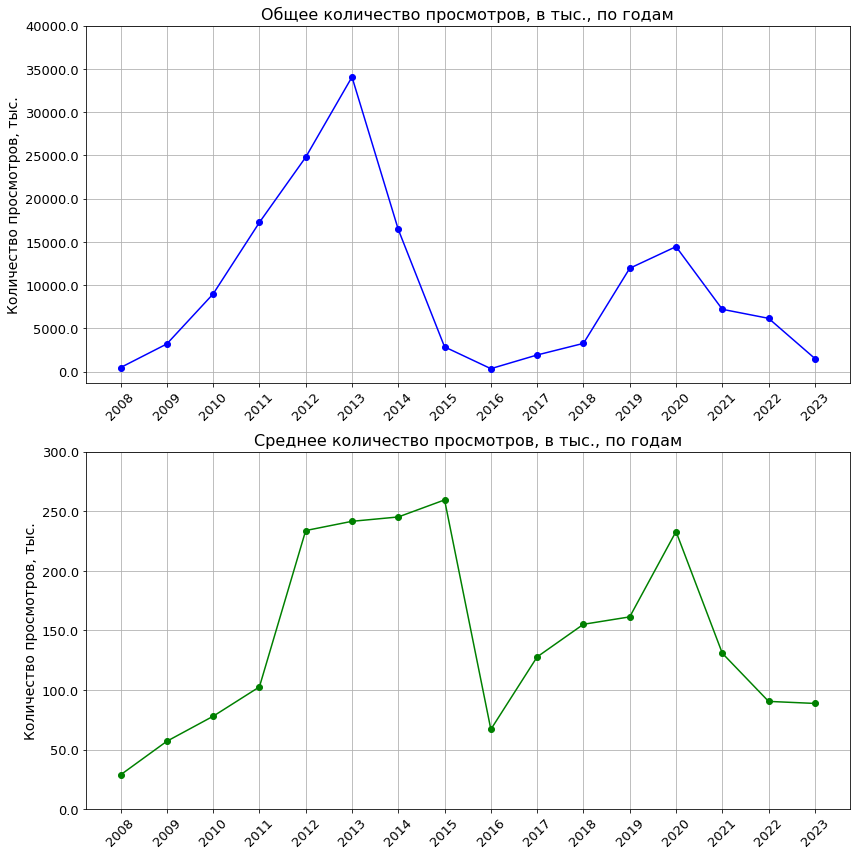

In [354]:
create_sum_mean_plot(period='year', name='по годам', rotation=45)

Примечательно, что графики общего и среднего количества просмотров постов в период с 2008 по 2023 гг. частично похожи, но не полностью совпадают. 

Наибольшее общее количество просмотров постов приходится на период с 2011 по 2014 гг., однако разница между наибольшим значением (показатель 2013 года) и показатель четвертого по величине годового значения (показатель 2014 года) составляет чуть менее, чем в 2 раза.

Примечательно также, что хотя среднее количество просмотров статьей в 2015 году наибольшее за рассматриваемый период, тем не менее, показатель общего количества просмотра один из самых низких. Это объясняется небольшим количеством опубликованных за этот год статей, которые получили значительное количество голосов пользователей. 

<a name='views_per_month'></a>
#### 4. 4. 2. Количество просмотров по месяцам
[Введение](#introduction)

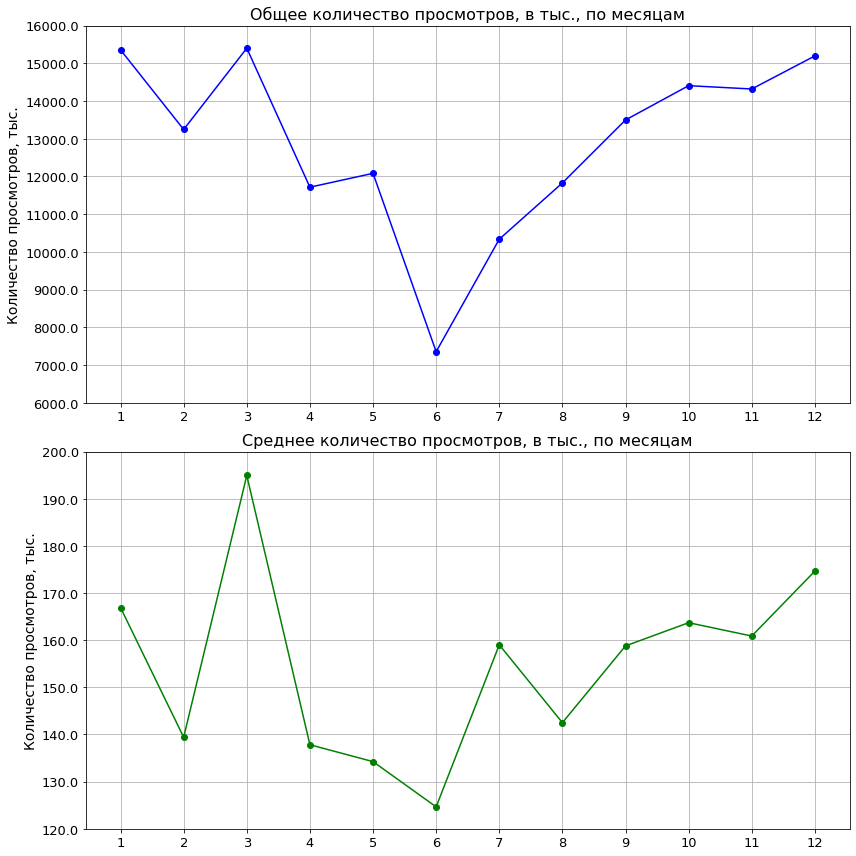

In [340]:
create_sum_mean_plot(period='month', name='по месяцам', rotation=0)

In [345]:
df_posts[df_posts['title'] == 'Коронавирус: почему надо действовать прямо сейчас']

,title,view_count,category,votes,year,month,day,hour,minute
67,Коронавирус: почему надо действовать прямо сейчас,5600.0,"[Открытые данные, Визуализация данных, Научно-...",456.0,2020,3,12,2,2


Наименьшее значение общего и среднего количества просмотров приходится на июнь. Вероятно, это связано с наступлением лета и с тем, что многие уезжают в отпуска, ввиду чего и активность снижается.

Хотя на апрель и май также в среднем приходится относительно немного просмотров - по 135-138 тыс. просмотров  соответственно, - тем не менее, по общему количеству просмотров они значительно опережают значение показателя количества просмотров в июне.

Наибольшее значение как по общему, так и по среднему количеству просмотров приходится на март, однако, необходимо учитывать, что именно в этот месяц была опубликована самая популярная статья на сайте - 'Коронавирус: почему надо действовать прямо сейчас', количество просмотров которой составляет 5.6 млн.

По графикам также можно отметить повышение с начала лета и до конца года общего и среднего количества просмотров.

<a name='views_per_day'></a>
#### 4. 4. 3. Количество просмотров по дням
[Введение](#introduction)

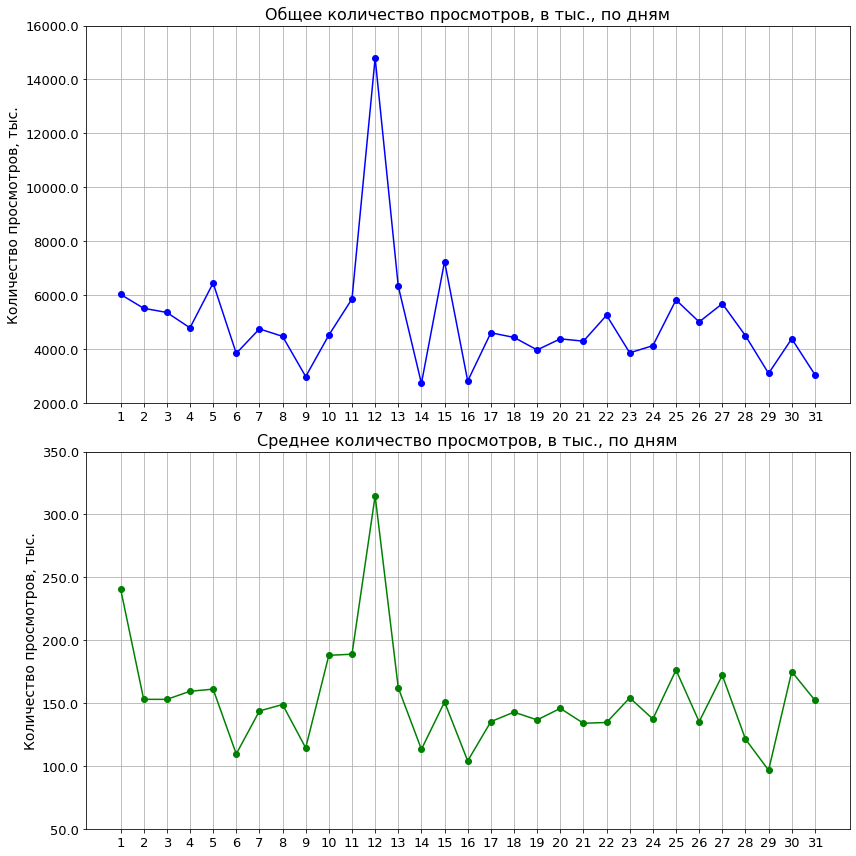

In [349]:
create_sum_mean_plot(period='day', name='по дням', rotation=0)

In [344]:
df_posts[df_posts['title'] == 'Коронавирус: почему надо действовать прямо сейчас']

,title,view_count,category,votes,year,month,day,hour,minute
67,Коронавирус: почему надо действовать прямо сейчас,5600.0,"[Открытые данные, Визуализация данных, Научно-...",456.0,2020,3,12,2,2


Большое значение 12 числа объясняется тем, что самая популярная по просмотрам статья 'Коронавирус: почему надо действовать прямо сейчас' (выведена выше) собрала 5.6 млн просмортов и была опубликована как раз 12 числа марта.

Тем не менее, по частым колебаниям графика сложно сделать вывод о каких-либо закономерностях в отношении дня публикации и количества просмотров. 

<a name='views_per_hour'></a>
#### 4. 4. 4. Количество просмотров по часам
[Введение](#introduction)

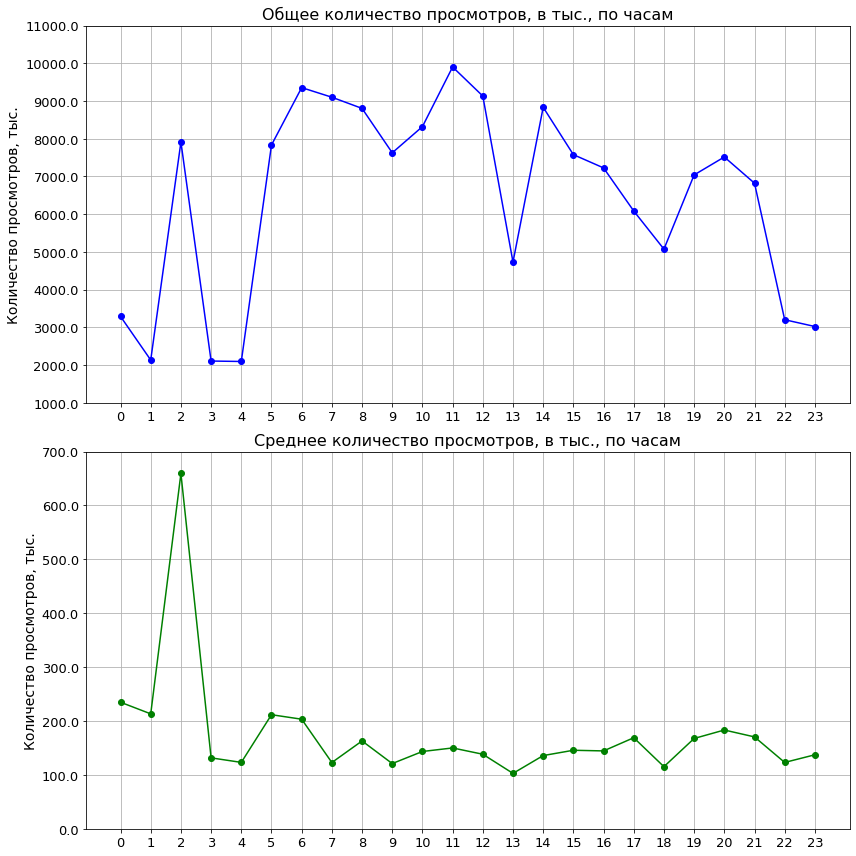

In [350]:
create_sum_mean_plot(period='hour', name='по часам', rotation=0)

В плане количества просмотров по часа информативней график по среднему значению. Если не брать во внимание значение "2" (снова время публикации самой популярной статьи), то среднее значение просмотров выглядит стабильным и находитс я в диапазоне от 100 до 200 тыс. просмотров. 


Можно, однако, заметить, что общее количество просмотров постов опубликованных ночью значительно ниже чем тех, которые были опубликованы в другое время суток. Вероятно, для получения наибольшего числа просмотров следует избегать публикации в период с 22 часов вечера до 4 часов ночи.

<a name='views_per_minute'></a>
#### 4. 4. 5. Количество просмотров по минутам
[Введение](#introduction)

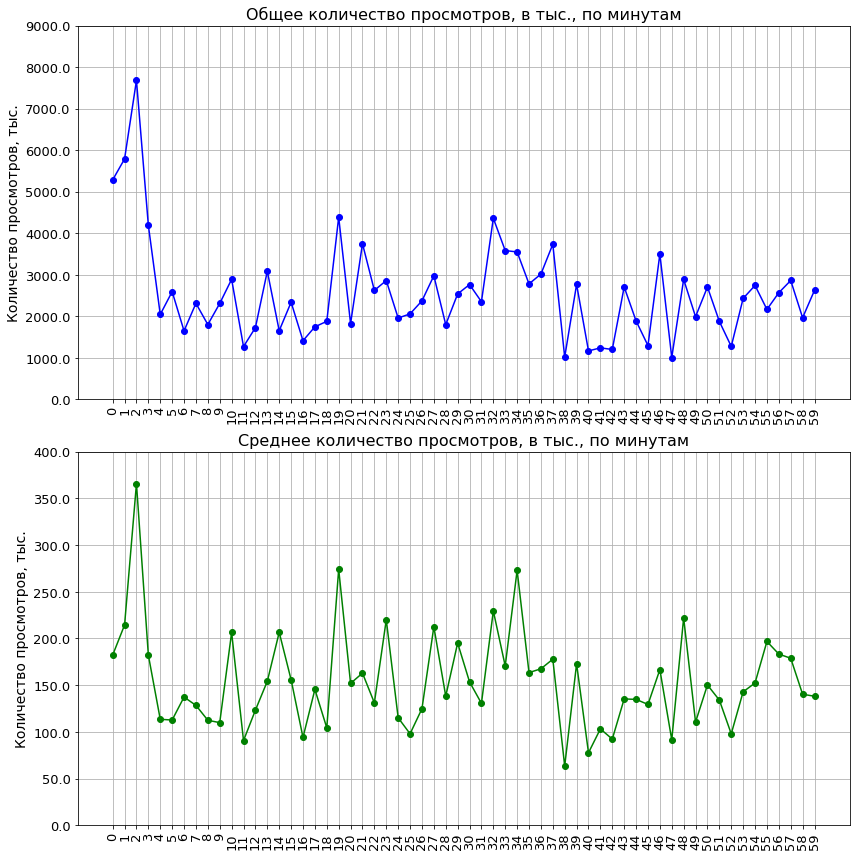

In [352]:
create_sum_mean_plot(period='minute', name='по минутам', rotation=90)

Ввиду сильной волатильности графика, определение корреляции между минутой публикации и количеством просмотров не представляется возможным. Более того, вероятно, в дальнейшем при создании ML-модели данный параметр будет негативно влиять на качество модели, ввиду чего возможно его удаление.

<a name='views_per_category'></a>
### 4. 5. Количество просмотров по категориям
[Введение](#introduction)

In [269]:
# Получим словарь уникальных категорий с количество статей по ним, а также общим количеством просмотров
unique_categories = {}
for index, row in df_posts.iterrows():
    for category in row['category']:
        if category not in unique_categories:
            unique_categories[category] = {'view_count': row['view_count'], 'count': 1}
        else:
            unique_categories[category]['view_count'] += row['view_count']
            unique_categories[category]['count'] +=1

# Запишем данные в отдельный датафрейм
categories_df = pd.DataFrame(unique_categories).T

# Добавим среднее значение просмотров по категориям
categories_df['avg'] = round(categories_df['view_count'] / categories_df['count'], 2)

print('Топ-10 категорий по общему количеству просмотров:')
display(categories_df.sort_values(by='view_count', ascending=False)[:10])
print('\nТоп-10 категорий по среднему количеству просмотров:')
display(categories_df.sort_values(by='avg', ascending=False)[:10])

Топ-10 категорий по общему количеству просмотров:


,view_count,count,avg
DIY или Сделай сам,18073.2,73.0,247.58
Информационная безопасность,17669.3,119.0,148.48
Научно-популярное,12337.2,52.0,237.25
Здоровье,10044.0,21.0,478.29
Карьера в IT-индустрии,8669.3,63.0,137.61
Биотехнологии,8228.0,17.0,484.00
Программирование,7935.9,63.0,125.97
Открытые данные,6342.0,5.0,1268.40
Алгоритмы,5837.0,27.0,216.19
Визуализация данных,5682.0,2.0,2841.00



Топ-10 категорий по среднему количеству просмотров:


,view_count,count,avg
Визуализация данных,5682.0,2.0,2841.00
Открытые данные,6342.0,5.0,1268.40
Администрирование доменных имен,1698.0,2.0,849.00
Серверное администрирование,1759.0,3.0,586.33
Блог компании Журнал Хакер,1715.0,3.0,571.67
Блог компании EPAM,555.0,1.0,555.00
Блог компании Vilianov Inc,971.0,2.0,485.50
Беспроводные технологии,1938.0,4.0,484.50
Биотехнологии,8228.0,17.0,484.00
Здоровье,10044.0,21.0,478.29


In [343]:
# Отобразим наименование статей, которые относятся к категориям "Визуализация данных" или "Открытые данные"
for key, row in df_posts.iterrows():
    for cat in row['category']:
        if cat == 'Визуализация данных' or cat == 'Открытые данные':
            print(f'Статья: "{row["title"]}"\n\tКоличество просмотров (в тыс.): {row["view_count"]}\n')

Статья: "Коронавирус: почему надо действовать прямо сейчас"
	Количество просмотров (в тыс.): 5600.0

Статья: "Коронавирус: почему надо действовать прямо сейчас"
	Количество просмотров (в тыс.): 5600.0

Статья: "Математическое расследование, как подделывали выборы губернатора в Приморье 16 сентября 2018 года"
	Количество просмотров (в тыс.): 96.0

Статья: "Sampler. Консольная утилита для визуализации результата любых shell команд"
	Количество просмотров (в тыс.): 82.0

Статья: "Коронавирусы: от SARS к 2019-nCoV"
	Количество просмотров (в тыс.): 332.0

Статья: "Спасем крупнейшую медиатеку в рунете. Вся база rutracker у Вас на компьютере"
	Количество просмотров (в тыс.): 193.0

Статья: "Истинные причины блокировок сайтов. Исследование по открытым данным"
	Количество просмотров (в тыс.): 121.0



Примечательно, лишь две категории из топ-10 по общему количеству просмотров также находятся в рейтинге топ-10 по среднему количеству просмотров: "здоровье" и "биотехнологии". В дополнение, статья под названием "Коронавирус: почему надо действовать прямо сейчас" с 5.6 млн просмотрами значительно увеличивает среднее значение просмотров категорий "визуализация данных" и "открытые данные", у которых в среднем по 2841 тыс. и 1268 тыс. просмотров соответственно.

<a name='popular_words'></a>
## 4. 6. Самые популярные слова в названиях постов
[Введение](#introduction)

Рассмотрим самые популярные слова в названиях постов по различных параметрам:
- [По частоте упоминаний](#words_per_frequency)
- [По обществу количеству просмотров](#words_per_views)
- [По количеству голосов](#words_per_votes)

In [504]:
# Сохраним в переменные стоп-слова на русском, а также лематизатор
russian_stopwords = stopwords.words('russian')
punctuation += '«»—'
m = Mystem()

# Лемматизация слов
def lemmatize(text):
    words = m.lemmatize(text)
    return ("".join(words).strip()).split()

In [534]:
# В словаре сохраним уникальные слова, а также кол-во их упоминаний, просмотров записей с ними и голосов
unique_words = {}
for key, row in df_posts.iterrows():
    text = row['title']
    tokens = nltk.word_tokenize(row['title'])
    tokens = " ".join(
        [token for token in tokens if token not in russian_stopwords and token not in punctuation]
    )
    words = lemmatize(tokens)
    for word in words:
        if word not in unique_words:
            unique_words[word] = {'count': 1, 'view_count': row['view_count'], 'votes': row['votes']}
        else:
            unique_words[word]['count'] += 1
            unique_words[word]['view_count'] += row['view_count']

# В отдельный датафрейм сохраним данные по топ-20 слов по частоте употребления
words_df = pd.DataFrame(unique_words).T.reset_index()
words_df.columns = ['word', 'count', 'view_count', 'votes']


# Функция для отображения топ-20 самых популярных слов по принимаемому на вход параметру 
def show_top_20_words(parameter, name):
    # Получение датафрейма из топ-20 слов и их параметрами
    top_20_words = words_df.sort_values(by=parameter, ascending=False)[:20]

    # Отобразим на графике топ-20 самых популярных слов
    plt.figure(figsize=(12, 8))
    plt.plot(
        top_20_words[parameter],
        top_20_words['word'],
        '-o',
        color='purple'
    )

    plt.title(f'Топ-20 самых популярных слов в названиях постов\n {name}', fontsize=TITLE_FONTSIZE)
    plt.xlabel('Количество', fontsize=LABEL_FONTSIZE)
    plt.xticks(fontsize=TICK_FONTSIZE)
    plt.ylabel('Слово', fontsize=LABEL_FONTSIZE)
    plt.yticks(fontsize=TICK_FONTSIZE)
    plt.grid()
    plt.show()

<a name='words_per_frequency'></a>
### 4. 6. 1. По частоте упоминаний
[Введение](#introduction)

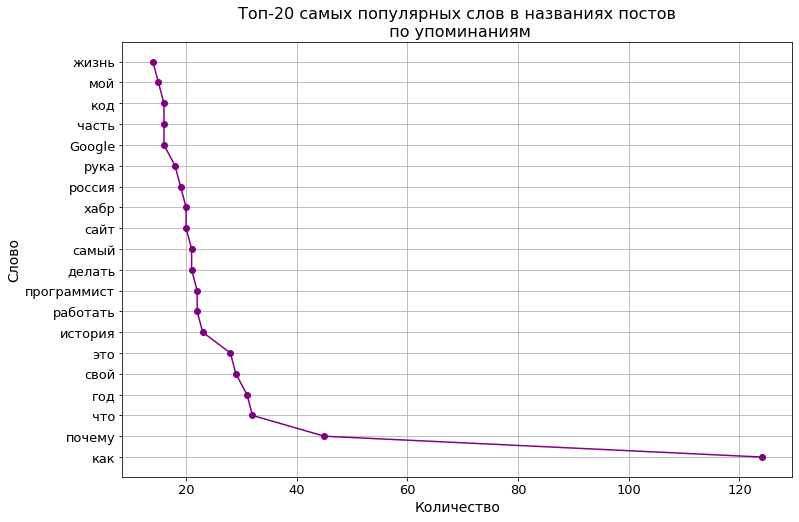

In [536]:
show_top_20_words('count', 'по частоте упоминаний')

# Добавить вывод

<a name='words_per_views'></a>
### 4. 6. 2. По обществу количеству просмотров
[Введение](#introduction)

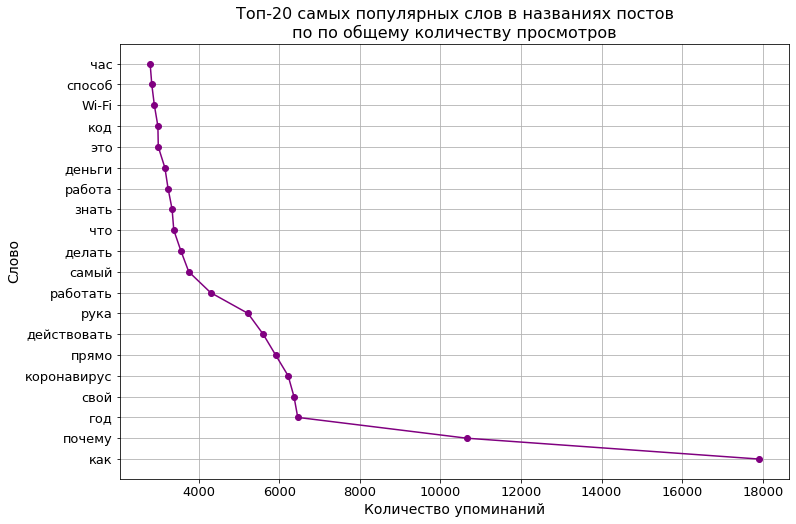

In [531]:
show_top_20_words('view_count', 'по общему количеству просмотров')

# Дописать вывод

<a name='words_per_votes'></a>
### 4. 6. 3. По количеству голосов
[Введение](#introduction)

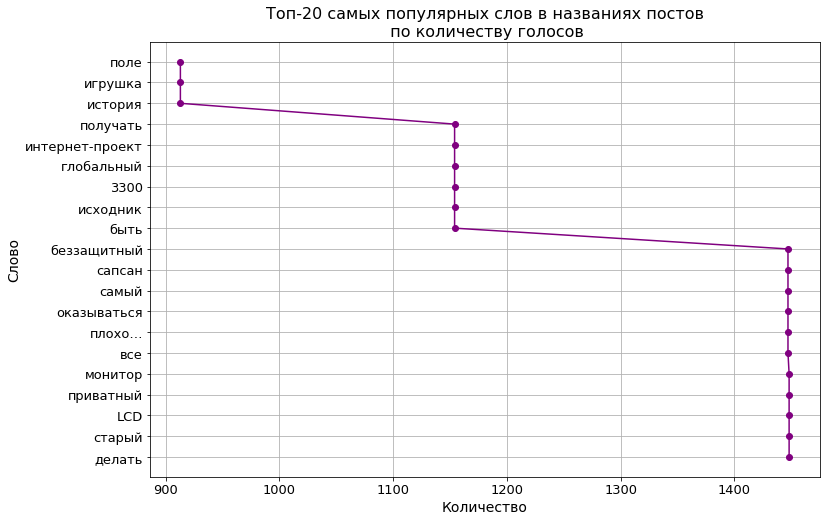

In [537]:
show_top_20_words('votes', 'по количеству голосов')

# Подкорректировать - график неверный
# + Вывод допиисать

### 4. ??? Корреляция phik
[Введение](#introduction)

interval columns not set, guessing: ['view_count', 'votes', 'year', 'month', 'day', 'hour', 'minute']


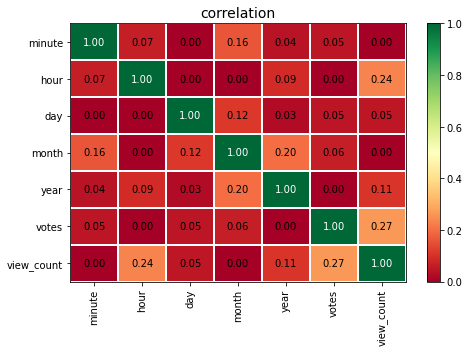

In [355]:
import phik
from phik.report import plot_correlation_matrix
from phik import report


df_posts_test = df_posts.drop(['category', 'title'], axis=1)

phik_overview = df_posts_test.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1
)